In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import sys
import os

# Caminho absoluto até a pasta src
src_path = Path.cwd().parent / "notebooks" / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
# Agora importa diretamente SEM prefixo
import leadscore_plot

from leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
dados_path = Path.cwd().parent / "dados"
df_leads = pd.read_parquet(dados_path / "leads.parquet")
df_alunos = pd.read_parquet(dados_path / "alunos.parquet")
df_invest_face = pd.read_parquet(dados_path / "invest_face.parquet")
df_invest_google = pd.read_parquet(dados_path / "invest_google.parquet")

In [3]:
df_leads.drop(columns=['email', 'whatsapp']).head()

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,comprou,utm_source,utm_medium,utm_campaign,utm_content,utm_term,escolaridade_original
0,2025-01-27 17:31:57,L32,SP,26 - 35 anos,médio completo,de 3.000 a 5.000,união estável,sim,sonho de criança,falta de base escolar,0,whatsapp,grupos antigos,l32,None,None,None
1,2024-11-20 10:56:47,L31,SP,46 - 55 anos,médio completo,até 1.000,divorciado(a) ou separado(a),sim,gosta da profissão,falta de oportunidade,0,instagram_feed,04_ll_1_envolvimento_30d,l31,video_vemai_v1,frio,None
2,2025-01-28 01:45:29,L32,SP,26 - 35 anos,fundamental completo,desempregado,solteiro(a),não,sonho de criança,financeiro / dinheiro,0,tva,04_afinidade_luta,l32,video_5_motivos_yt,None,None
3,2025-03-17 20:27:57,L33,SP,26 - 35 anos,médio completo,desempregado,solteiro(a),sim,sonho de criança,financeiro / dinheiro,0,instagram,bio,l33,None,None,None
4,2025-03-23 22:39:51,L33,SP,26 - 35 anos,médio completo,de 1.000 a 3.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,0,instagram_stories,04_ll_10_lista_de_alunos,l33,video_vemai_v1_pag_f,frio,None


In [4]:
df_invest_face.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       1359 non-null   object 
 1   campaign                   1359 non-null   object 
 2   adset_name                 1359 non-null   object 
 3   ad_name                    1359 non-null   object 
 4   spend                      1359 non-null   float64
 5   impressions                1359 non-null   int64  
 6   actions_link_click         1359 non-null   int64  
 7   actions_landing_page_view  1359 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 85.1+ KB


In [5]:
df_invest_face["spend"].sum()

46509.369999999995

In [6]:
df_invest_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         87 non-null     object 
 1   campaign     87 non-null     object 
 2   clicks       87 non-null     int64  
 3   spend        87 non-null     float64
 4   impressions  87 non-null     int64  
 5   conversions  87 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.2+ KB


In [7]:
df_invest_google["spend"].sum()

26492667.0

In [8]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38893 entries, 0 to 38892
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data                   38893 non-null  datetime64[ns]
 1   lancamentos            38893 non-null  object        
 2   email                  38893 non-null  object        
 3   whatsapp               38893 non-null  object        
 4   estado                 38893 non-null  object        
 5   idade                  38893 non-null  object        
 6   escolaridade           38893 non-null  object        
 7   renda                  38893 non-null  object        
 8   estado_civil           38893 non-null  object        
 9   filhos                 38893 non-null  object        
 10  escolheu_profissao     38893 non-null  object        
 11  dificuldade            38893 non-null  object        
 12  comprou                38893 non-null  int32         
 13  u

In [9]:
df_alunos.drop(columns=['email', 'whatsapp']).head()

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,comprou,utm_source,utm_medium,utm_campaign,utm_content,utm_term
0,2024-07-29 13:51:00,L29,SP,46 - 55 anos,médio completo,de 3.000 a 5.000,casado(a),sim,gosta da profissão,financeiro / dinheiro,1,youtube,comunidade,l29,posts,None
1,2024-09-20 11:44:00,L30,SP,46 - 55 anos,médio completo,de 3.000 a 5.000,casado(a),sim,sonho de criança,financeiro / dinheiro,1,tva,00_envolvimento_yt_180d,l30,video_atras_do_sonho_v1_yt,None
2,2025-03-21 11:38:46,L33,SP,46 - 55 anos,superior completo,desempregado,casado(a),não,gosta da profissão,idade,1,tva,00_envolvimento_yt_180d,l33,video_caminhoneiro_yt,None
3,2025-01-28 18:52:59,L32,SP,até 25 anos,médio completo,de 1.000 a 3.000,casado(a),não,sonho de criança,idade,1,instagram,manychat,l32,None,None
4,2025-01-20 08:28:02,L32,RJ,36 - 45 anos,superior completo,de 1.000 a 3.000,casado(a),não,gosta da profissão,falta de tempo,1,tva,04_mercado_concurso,l32,video_entrevista_v2_yt,None


In [10]:
df_alunos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                260 non-null    datetime64[ns]
 1   lancamentos         260 non-null    object        
 2   email               260 non-null    object        
 3   whatsapp            260 non-null    object        
 4   estado              260 non-null    object        
 5   idade               260 non-null    object        
 6   escolaridade        260 non-null    object        
 7   renda               260 non-null    object        
 8   estado_civil        260 non-null    object        
 9   filhos              260 non-null    object        
 10  escolheu_profissao  260 non-null    object        
 11  dificuldade         260 non-null    object        
 12  comprou             260 non-null    int32         
 13  utm_source          259 non-null    object        

In [11]:
for col in df_leads.select_dtypes(include=["object"]).columns:
    if col not in ["data", "email", "whatsapp"]:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_leads[col].value_counts(dropna=False))


====== VARIÁVEL: LANCAMENTOS ======

lancamentos
L34    28030
L32     4875
L31     2657
L33     2461
L30      352
L28      275
L29      243
Name: count, dtype: int64

====== VARIÁVEL: ESTADO ======

estado
SP                            22242
Outro                          8219
MG                             3960
RJ                             2326
PR                             1709
MA                              231
BA                               38
SC                               38
RS                               33
PE                               25
GO                               22
CE                               18
AL                               10
DF                                4
RN                                2
AM                                2
Florianópolis                     1
ES                                1
RO                                1
Caixa dosur                       1
Vitória de Santo Antão            1
Piauí                             1
R

In [12]:
colunas_excluir = ["data", "email", "whatsapp"]

for col in df_alunos.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_alunos[col].value_counts(dropna=False))


====== VARIÁVEL: LANCAMENTOS ======

lancamentos
L32    88
L31    71
L33    47
L30    24
L28    18
L29    12
Name: count, dtype: int64

====== VARIÁVEL: ESTADO ======

estado
SP       226
RJ        16
MG        13
Outro      3
DF         1
PR         1
Name: count, dtype: int64

====== VARIÁVEL: IDADE ======

idade
36 - 45 anos        101
26 - 35 anos         86
46 - 55 anos         53
até 25 anos          17
acima de 56 anos      3
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ======

escolaridade
médio completo          185
superior completo        53
fundamental completo     14
superior incompleto       4
técnico                   3
médio incompleto          1
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
de 1.000 a 3.000    139
de 3.000 a 5.000     63
desempregado         26
acima de 5.000       21
até 1.000            11
Name: count, dtype: int64

====== VARIÁVEL: ESTADO_CIVIL ======

estado_civil
casado(a)                       133
solteiro(a)       

In [13]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    # Padroniza e remove nulos reais e disfarçados
    def limpar_coluna(df):
        return df[df[col].notna() & ~df[col].astype(str).str.strip().isin(["", "nan", "NaN", "None", "none"])]

    df_leads = limpar_coluna(df_leads)
    df_alunos = limpar_coluna(df_alunos)
    
    ciclos = pd.Index(df_alunos[col_lancamento].dropna().unique()).union(
        df_leads[col_lancamento].dropna().unique()
    )

    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas.apply(
            lambda row: row["percentual_alunos"] / row["percentual_leads"] if row["percentual_leads"] > 0 else 0,
            axis=1
        )
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift_vals = grupo["lift"].replace([np.inf, -np.inf], 0)
        lift = (lift_vals * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0

        score_vals = grupo["score"].replace([np.inf, -np.inf], 0)
        score = score_vals.sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    return tabela_final.sort_values(by="score", ascending=False)

In [14]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "renda",
    "escolaridade",
    "idade",
    "filhos",
    "estado_civil",
    "escolheu_profissao"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)

    # Colunas a somar (ignorando 'lift' e 'score')
    colunas_para_somar = [
        col for col in tabela.columns
        if col not in ["lift", "score", "percentual_alunos", "percentual_leads"]
        and pd.api.types.is_numeric_dtype(tabela[col])
    ]

    # Criar linha de total
    totais = tabela[colunas_para_somar].sum().to_frame().T
    totais.index = ["Total"]

    # Preencher colunas restantes com vazio ou marcador
    for col in tabela.columns:
        if col not in totais.columns:
            totais[col] = "-"

    # Reordenar para manter consistência
    totais = totais[tabela.columns]

    # Concatenar com a tabela original
    tabela_com_total = pd.concat([tabela, totais], axis=0)

    display(tabela_com_total)


=== TABELA: renda ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
de 1.000 a 3.000,19726.0,139.0,51.07,54.09,1.03,142.65
de 3.000 a 5.000,9515.0,63.0,24.67,25.48,1.13,70.9
desempregado,2874.0,26.0,7.47,12.56,1.51,39.18
acima de 5.000,2763.0,21.0,7.19,10.5,1.83,38.49
até 1.000,3766.0,11.0,9.77,5.31,0.53,5.77
Total,38644.0,260.0,-,-,-,-



=== TABELA: escolaridade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
médio completo,26601.0,185.0,72.84,72.04,0.99,182.69
superior completo,5377.0,53.0,14.91,23.22,1.37,72.45
superior incompleto,105.0,4.0,1.35,2.54,4.47,17.88
fundamental completo,4374.0,14.0,12.45,5.54,0.69,9.71
técnico,17.0,1.0,0.15,1.14,5.04,5.04
fundamental incompleto,13.0,0.0,0.06,0.0,0.0,0.0
Total,36487.0,257.0,-,-,-,-



=== TABELA: idade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
36 - 45 anos,15235.0,101.0,39.67,40.36,1.06,107.45
26 - 35 anos,11986.0,86.0,31.22,34.04,1.11,95.07
46 - 55 anos,7635.0,53.0,20.11,22.14,1.09,57.91
até 25 anos,3045.0,17.0,8.01,7.03,1.0,16.92
acima de 56 anos,525.0,3.0,1.45,2.59,1.26,3.78
Total,38426.0,260.0,-,-,-,-



=== TABELA: filhos ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
sim,28890.0,181.0,74.68,70.2,0.97,176.15
não,9817.0,79.0,25.48,31.71,1.13,89.09
Total,38707.0,260.0,-,-,-,-



=== TABELA: estado_civil ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
casado(a),13928.0,133.0,36.21,52.66,1.33,177.41
solteiro(a),15547.0,85.0,40.36,34.18,0.84,71.18
união estável,4352.0,25.0,11.37,10.19,0.96,24.0
divorciado(a) ou separado(a),4067.0,17.0,10.85,8.98,0.75,12.83
outros,632.0,0.0,2.28,0.0,0.0,0.0
viúvo(a),7.0,0.0,0.14,0.0,0.0,0.0
Total,38533.0,260.0,-,-,-,-



=== TABELA: escolheu_profissao ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
sonho de criança,13293.0,101.0,34.31,39.14,1.09,110.46
gosta da profissão,12433.0,90.0,32.16,34.99,1.0,90.11
prestígio da carreira,3762.0,36.0,9.72,18.04,1.66,59.74
estabilidade de emprego,6406.0,29.0,16.81,13.01,0.67,19.33
segurança,1439.0,4.0,4.64,4.53,3.39,13.56
outros,1430.0,0.0,5.12,0.0,0.0,0.0
Total,38763.0,260.0,-,-,-,-


In [15]:
# Função auxiliar para listar valores únicos, já aplicando strip
def listar_valores_unicos(df, coluna):
    return sorted({str(v).strip() for v in df[coluna].dropna().unique()})

# Loop pelas variáveis
for coluna in features_alunos:
    print(f"\n\n=== VARIÁVEL: {coluna.upper()} ===")

    valores_leads = listar_valores_unicos(df_leads, coluna)
    valores_alunos = listar_valores_unicos(df_alunos, coluna)

    print("\n🎯 Valores em df_leads:")
    for v in valores_leads:
        print(f"- '{v}'")

    print("\n🎯 Valores em df_alunos:")
    for v in valores_alunos:
        print(f"- '{v}'")

    print("\n🚨 Categorias nos leads mas não nos alunos:")
    diferenca_leads = set(valores_leads) - set(valores_alunos)
    print(diferenca_leads if diferenca_leads else "Nenhuma diferença.")

    print("\n🚨 Categorias nos alunos mas não nos leads:")
    diferenca_alunos = set(valores_alunos) - set(valores_leads)
    print(diferenca_alunos if diferenca_alunos else "Nenhuma diferença.")



=== VARIÁVEL: RENDA ===

🎯 Valores em df_leads:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'
- 'none'

🎯 Valores em df_alunos:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'

🚨 Categorias nos leads mas não nos alunos:
{'none'}

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: ESCOLARIDADE ===

🎯 Valores em df_leads:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'médio incompleto'
- 'none'
- 'superior completo'
- 'superior incompleto'
- 'técnico'

🎯 Valores em df_alunos:
- 'fundamental completo'
- 'médio completo'
- 'médio incompleto'
- 'superior completo'
- 'superior incompleto'
- 'técnico'

🚨 Categorias nos leads mas não nos alunos:
{'none', 'fundamental incompleto'}

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: IDADE ===

🎯 Valores em df_leads:
- '26 - 35 anos'
- '36 - 45 anos'
- '46 - 55 anos'
- 'acima 

In [16]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [17]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: RENDA ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,154,11,56.00,61.11
de 3.000 a 5.000,51,5,18.55,27.78
até 1.000,36,1,13.09,5.56
desempregado,27,0,9.82,0.00
acima de 5.000,7,1,2.55,5.56



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,131,5,53.91,41.67
de 3.000 a 5.000,45,3,18.52,25.00
desempregado,28,3,11.52,25.00
até 1.000,25,0,10.29,0.00
acima de 5.000,14,1,5.76,8.33



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,189,12,53.69,50.00
de 3.000 a 5.000,75,2,21.31,8.33
até 1.000,44,2,12.50,8.33
desempregado,26,3,7.39,12.50
acima de 5.000,18,5,5.11,20.83



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,1377,43,51.83,60.56
de 3.000 a 5.000,607,16,22.85,22.54
até 1.000,257,2,9.67,2.82
desempregado,215,7,8.09,9.86
acima de 5.000,201,3,7.56,4.23



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,2582,46,52.96,52.27
de 3.000 a 5.000,1156,24,23.71,27.27
até 1.000,430,5,8.82,5.68
desempregado,384,6,7.88,6.82
acima de 5.000,323,7,6.63,7.95



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,1269,22,51.56,46.81
de 3.000 a 5.000,582,13,23.65,27.66
até 1.000,235,1,9.55,2.13
acima de 5.000,190,4,7.72,8.51
desempregado,185,7,7.52,14.89



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,195,13,70.91,72.22
superior completo,37,3,13.45,16.67
fundamental completo,26,1,9.45,5.56
superior incompleto,8,0,2.91,0.00
fundamental incompleto,3,0,1.09,0.00
médio incompleto,3,1,1.09,5.56
técnico,3,0,1.09,0.00



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,169,9,69.55,75.00
superior completo,43,2,17.70,16.67
fundamental completo,17,1,7.00,8.33
superior incompleto,8,0,3.29,0.00
técnico,3,0,1.23,0.00
médio incompleto,3,0,1.23,0.00



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,260,21,73.86,87.50
superior completo,46,1,13.07,4.17
fundamental completo,25,1,7.10,4.17
superior incompleto,15,0,4.26,0.00
técnico,4,1,1.14,4.17
fundamental incompleto,2,0,0.57,0.00



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,1935,53,72.83,74.65
superior completo,495,12,18.63,16.90
fundamental completo,205,4,7.72,5.63
superior incompleto,16,2,0.60,2.82
médio incompleto,3,0,0.11,0.00
técnico,2,0,0.08,0.00
fundamental incompleto,1,0,0.04,0.00



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,3614,54,74.13,61.36
superior completo,834,26,17.11,29.55
fundamental completo,382,5,7.84,5.68
superior incompleto,26,2,0.53,2.27
técnico,11,1,0.23,1.14
fundamental incompleto,5,0,0.10,0.00
médio incompleto,3,0,0.06,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,1790,35,72.73,74.47
superior completo,395,9,16.05,19.15
fundamental completo,266,2,10.81,4.26
superior incompleto,7,0,0.28,0.00
técnico,2,1,0.08,2.13
médio incompleto,1,0,0.04,0.00



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: IDADE ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,105,5,38.18,27.78
26 - 35 anos,93,9,33.82,50.00
46 - 55 anos,55,3,20.00,16.67
até 25 anos,22,1,8.00,5.56



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,101,5,41.56,41.67
26 - 35 anos,64,5,26.34,41.67
46 - 55 anos,62,2,25.51,16.67
até 25 anos,12,0,4.94,0.00
acima de 56 anos,4,0,1.65,0.00



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,131,11,37.22,45.83
26 - 35 anos,114,7,32.39,29.17
46 - 55 anos,73,4,20.74,16.67
até 25 anos,25,2,7.10,8.33
acima de 56 anos,9,0,2.56,0.00



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,973,34,36.62,47.89
26 - 35 anos,762,22,28.68,30.99
46 - 55 anos,733,9,27.59,12.68
até 25 anos,135,4,5.08,5.63
acima de 56 anos,54,2,2.03,2.82



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,1907,33,39.12,37.50
26 - 35 anos,1587,26,32.55,29.55
46 - 55 anos,936,22,19.20,25.00
até 25 anos,381,7,7.82,7.95
acima de 56 anos,64,0,1.31,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,967,13,39.29,27.66
26 - 35 anos,750,17,30.48,36.17
46 - 55 anos,489,13,19.87,27.66
até 25 anos,203,3,8.25,6.38
acima de 56 anos,52,1,2.11,2.13



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: FILHOS ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,199,16,72.36,88.89
não,76,2,27.64,11.11



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,183,10,75.31,83.33
não,60,2,24.69,16.67



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,253,16,71.88,66.67
não,99,8,28.12,33.33



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,1919,49,72.22,69.01
não,738,22,27.78,30.99



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,3486,58,71.51,65.91
não,1389,30,28.49,34.09



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,1769,32,71.88,68.09
não,692,15,28.12,31.91



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESTADO_CIVIL ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
casado(a),123,13,44.73,72.22
solteiro(a),113,2,41.09,11.11
união estável,39,3,14.18,16.67



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
casado(a),121,8,49.79,66.67
solteiro(a),80,3,32.92,25.00
união estável,40,1,16.46,8.33
viúvo(a),2,0,0.82,0.00



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),163,9,46.31,37.50
casado(a),142,13,40.34,54.17
união estável,44,2,12.50,8.33
viúvo(a),2,0,0.57,0.00
divorciado(a),1,0,0.28,0.00



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),1034,24,38.92,33.80
casado(a),1031,34,38.80,47.89
divorciado(a) ou separado(a),349,5,13.14,7.04
união estável,242,8,9.11,11.27
viúvo(a),1,0,0.04,0.00



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),2020,28,41.44,31.82
casado(a),1810,47,37.13,53.41
divorciado(a) ou separado(a),531,6,10.89,6.82
união estável,507,7,10.40,7.95
viúvo(a),7,0,0.14,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),1010,19,41.04,40.43
casado(a),908,18,36.90,38.30
divorciado(a) ou separado(a),295,6,11.99,12.77
união estável,248,4,10.08,8.51



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLHEU_PROFISSAO ======


--- Lançamento: L28 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
sonho de criança,110,6,40.00,33.33
gosta da profissão,90,5,32.73,27.78
prestígio da carreira,34,7,12.36,38.89
estabilidade de emprego,25,0,9.09,0.00
segurança,16,0,5.82,0.00



--- Lançamento: L29 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
sonho de criança,95,6,39.09,50.00
gosta da profissão,83,4,34.16,33.33
estabilidade de emprego,34,0,13.99,0.00
prestígio da carreira,23,1,9.47,8.33
segurança,8,1,3.29,8.33



--- Lançamento: L30 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
sonho de criança,132,9,37.50,37.50
gosta da profissão,125,7,35.51,29.17
prestígio da carreira,44,5,12.50,20.83
estabilidade de emprego,37,2,10.51,8.33
segurança,14,1,3.98,4.17



--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
gosta da profissão,935,25,35.19,35.21
sonho de criança,887,27,33.38,38.03
estabilidade de emprego,575,11,21.64,15.49
prestígio da carreira,245,6,9.22,8.45
segurança,15,2,0.56,2.82



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
gosta da profissão,1722,34,35.32,38.64
sonho de criança,1716,33,35.20,37.50
estabilidade de emprego,945,10,19.38,11.36
prestígio da carreira,457,11,9.37,12.50
segurança,35,0,0.72,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
sonho de criança,916,20,37.22,42.55
gosta da profissão,841,15,34.17,31.91
estabilidade de emprego,471,6,19.14,12.77
prestígio da carreira,226,6,9.18,12.77
segurança,7,0,0.28,0.00



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.


In [18]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    
    # Normalizar apenas tirando espaços (NÃO converte para minúsculo)
    score_map[col] = {
        str(k).strip(): v
        for k, v in zip(tabela.index, tabela["score"])
    }

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()  # Agora só strip, sem lower
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 3420
Score mínimo: 0.0
Score máximo: 896.8100000000001
Top 5 scores mais comuns:
leadscore_mapeado
896.81    659
876.46    616
778.20    531
790.58    494
884.43    464
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 173
Score mínimo: 301.27
Score máximo: 896.8100000000001
Top 5 scores mais comuns:
leadscore_mapeado
896.81    10
691.14     9
876.46     8
884.43     6
825.06     5
Name: count, dtype: int64


In [19]:
# Loop para todas as variáveis
for col in features_alunos:
    print(f"\n====== VARIÁVEL: {col.upper()} ======\n")

    valores_no_df = sorted(df_leads[col].dropna().unique())
    valores_no_map = sorted(score_map.get(col, {}).keys())

    print("❗Valores no df_leads:")
    for v in valores_no_df:
        print(f"- '{v}'")

    print("\n✅ Valores no score_map:")
    for v in valores_no_map:
        print(f"- '{v}'")

    print("\n" + "="*50)


====== VARIÁVEL: RENDA ======

❗Valores no df_leads:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'
- 'none'

✅ Valores no score_map:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'


====== VARIÁVEL: ESCOLARIDADE ======

❗Valores no df_leads:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'médio incompleto'
- 'none'
- 'superior completo'
- 'superior incompleto'
- 'técnico'

✅ Valores no score_map:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'superior completo'
- 'superior incompleto'
- 'técnico'


====== VARIÁVEL: IDADE ======

❗Valores no df_leads:
- '26 - 35 anos'
- '36 - 45 anos'
- '46 - 55 anos'
- 'acima de 56 anos'
- 'até 25 anos'
- 'none'

✅ Valores no score_map:
- '26 - 35 anos'
- '36 - 45 anos'
- '46 - 55 anos'
- 'acima de 56 anos'
- 'até 25 anos'


====== VARIÁVEL: FILHOS ======

❗Valores no df_leads:
- 'none'
- 'não'
- 'sim'

✅ Valo

In [20]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 684
Limite A (>= 110%): 752
Limite B (>=  90%): 616
Limite C (>=  70%): 479
Limite D (>=  50%): 342


In [21]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


,faixa_origem,faixa_destino,variavel,categoria,% A,% B,diferença entre A e B
29,A,B,estado_civil,casado(a),79.52,35.21,44.31
0,A,B,renda,de 1.000 a 3.000,73.48,55.33,18.15
27,A,B,estado_civil,solteiro(a),20.48,38.04,-17.57
6,A,B,escolaridade,médio completo,96.97,79.85,17.12
20,A,B,filhos,sim,95.96,81.32,14.64
22,A,B,filhos,não,4.04,18.56,-14.52
23,A,B,estado_civil,união estável,0.00,13.88,-13.88
25,A,B,estado_civil,divorciado(a) ou separado(a),0.00,11.10,-11.10
41,A,B,escolheu_profissao,gosta da profissão,39.76,31.32,8.44
11,A,B,escolaridade,superior completo,3.03,11.36,-8.33


🟡 B → C


,faixa_origem,faixa_destino,variavel,categoria,% B,% C,diferença entre B e C
6,B,C,escolaridade,médio completo,79.85,53.18,26.67
20,B,C,filhos,sim,81.32,60.62,20.69
22,B,C,filhos,não,18.56,39.13,-20.57
29,B,C,estado_civil,casado(a),35.21,15.69,19.52
27,B,C,estado_civil,solteiro(a),38.04,52.25,-14.21
0,B,C,renda,de 1.000 a 3.000,55.33,41.23,14.11
14,B,C,idade,36 - 45 anos,44.00,30.96,13.04
34,B,C,escolheu_profissao,sonho de criança,37.65,27.23,10.42
18,B,C,idade,até 25 anos,2.92,13.28,-10.36
7,B,C,escolaridade,fundamental completo,6.60,16.76,-10.16


🔴 C → D


,faixa_origem,faixa_destino,variavel,categoria,% C,% D,diferença entre C e D
6,C,D,escolaridade,médio completo,53.18,17.05,36.13
0,C,D,renda,de 1.000 a 3.000,41.23,16.76,24.47
5,C,D,renda,até 1.000,12.11,29.52,-17.42
7,C,D,escolaridade,fundamental completo,16.76,33.02,-16.26
12,C,D,escolaridade,none,8.57,24.00,-15.43
20,C,D,filhos,sim,60.62,45.36,15.26
32,C,D,estado_civil,casado(a),15.69,3.09,12.60
22,C,D,filhos,não,39.13,51.63,-12.50
18,C,D,idade,até 25 anos,13.28,22.38,-9.10
14,C,D,idade,36 - 45 anos,30.96,23.04,7.92


In [22]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa,variavel,categoria,A,B,C,D
2,escolaridade,médio completo,96.97,79.85,53.18,17.05
5,escolaridade,superior completo,3.03,11.36,20.77,24.81
0,escolaridade,fundamental completo,0.00,6.60,16.76,33.02
1,escolaridade,fundamental incompleto,0.00,0.02,0.06,0.19
3,escolaridade,médio incompleto,0.00,0.02,0.05,0.17
4,escolaridade,none,0.00,1.91,8.57,24.00
6,escolaridade,superior incompleto,0.00,0.20,0.44,0.60
7,escolaridade,técnico,0.00,0.04,0.16,0.15
29,escolheu_profissao,sonho de criança,43.84,37.65,27.23,22.40
14,escolheu_profissao,gosta da profissão,39.76,31.32,30.20,23.32


In [23]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 8952 (23.0%)
B: 13842 (35.6%)
C: 11408 (29.3%)
D: 4691 (12.1%)

----------------------------------------

ALUNOS
A: 85 (32.7%)
B: 94 (36.2%)
C: 66 (25.4%)
D: 15 (5.8%)


In [24]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento: L28 (n = 275)
  A: 30.5%
  B: 39.3%
  C: 24.4%
  D: 5.8%
------------------------------
Lançamento: L29 (n = 243)
  A: 31.7%
  B: 38.7%
  C: 19.3%
  D: 10.3%
------------------------------
Lançamento: L30 (n = 352)
  A: 27.8%
  B: 41.5%
  C: 22.2%
  D: 8.5%
------------------------------
Lançamento: L31 (n = 2657)
  A: 25.8%
  B: 37.3%
  C: 28.5%
  D: 8.4%
------------------------------
Lançamento: L32 (n = 4875)
  A: 27.0%
  B: 38.3%
  C: 26.7%
  D: 8.1%
------------------------------
Lançamento: L33 (n = 2461)
  A: 26.2%
  B: 36.2%
  C: 29.1%
  D: 8.5%
------------------------------
Lançamento: L34 (n = 28030)
  A: 21.6%
  B: 34.8%
  C: 30.1%
  D: 13.5%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento: L28 (n = 18)
  A: 55.6%
  B: 22.2%
  C: 22.2%
------------------------------
Lançamento: L29 (n = 12)
  A: 41.7%
  B: 33.3%
  C: 16.7%
  D: 8.3%
------------------------------
Lançamento: L30 

In [25]:
tabela_pct = pd.crosstab(df_leads['estado'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
estado,,,,,,,
AL,0.00,0.00,0.28,0.00,0.02,0.00,0.03
AM,0.00,0.00,0.28,0.00,0.00,0.00,0.00
BA,0.73,0.82,0.85,0.04,0.10,0.00,0.09
CE,0.00,0.00,0.00,0.00,0.04,0.00,0.06
CE,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Caixa dosur,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Conde,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Cuiabá-MT,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DF,0.00,0.00,0.00,0.00,0.02,0.00,0.01


In [26]:
tabela_pct = pd.crosstab(df_leads['renda'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
renda,,,,,,,
acima de 5.000,2.55,5.76,5.11,7.56,6.63,7.72,7.17
até 1.000,13.09,10.29,12.50,9.67,8.82,9.55,9.77
de 1.000 a 3.000,56.00,53.91,53.69,51.83,52.96,51.56,50.03
de 3.000 a 5.000,18.55,18.52,21.31,22.85,23.71,23.65,24.97
desempregado,9.82,11.52,7.39,8.09,7.88,7.52,7.17
none,0.00,0.00,0.00,0.00,0.00,0.00,0.89


In [27]:
tabela_pct = pd.crosstab(df_leads['escolaridade'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
escolaridade,,,,,,,
fundamental completo,9.45,7.00,7.10,7.72,7.84,10.81,12.32
fundamental incompleto,1.09,0.00,0.57,0.04,0.10,0.00,0.03
médio completo,70.91,69.55,73.86,72.83,74.13,72.73,66.49
médio incompleto,1.09,1.23,0.00,0.11,0.06,0.04,0.01
none,0.00,0.00,0.00,0.00,0.00,0.00,8.45
superior completo,13.45,17.70,13.07,18.63,17.11,16.05,12.58
superior incompleto,2.91,3.29,4.26,0.60,0.53,0.28,0.09
técnico,1.09,1.23,1.14,0.08,0.23,0.08,0.02


In [28]:
tabela_pct = pd.crosstab(df_leads['escolheu_profissao'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
escolheu_profissao,,,,,,,
a lei foi instruída pelo profeta moisés pelo criador jeová,0.00,0.00,0.00,0.00,0.00,0.00,0.00
detetive,0.00,0.00,0.00,0.00,0.00,0.00,0.00
estabilidade de emprego,9.09,13.99,10.51,21.64,19.38,19.14,15.41
estabilidade e amor a profissão,0.00,0.00,0.00,0.00,0.00,0.00,0.00
estudo criminologia e quero atuar na áreas,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ganhar um bom dinheiro,0.00,0.00,0.00,0.00,0.00,0.00,0.00
gosta da profissão,32.73,34.16,35.51,35.19,35.32,34.17,30.81
gosto da profissão,0.00,0.00,0.00,0.00,0.00,0.00,0.00
inspiração meu pai,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [29]:
tabela_pct = pd.crosstab(df_leads['estado_civil'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
estado_civil,,,,,,,
amasiado,0.00,0.00,0.00,0.00,0.00,0.00,0.00
casado,0.00,0.00,0.00,0.00,0.00,0.00,0.00
casado mas nada no papel a mais de 10 anos,0.00,0.00,0.00,0.00,0.00,0.00,0.00
casado(a),44.73,49.79,40.34,38.80,37.13,36.90,34.94
divorciado(a),0.00,0.00,0.28,0.00,0.00,0.00,0.00
divorciado(a) ou separado(a),0.00,0.00,0.00,13.14,10.89,11.99,10.32
morando junto mais nao no papel,0.00,0.00,0.00,0.00,0.00,0.00,0.00
morro jinto,0.00,0.00,0.00,0.00,0.00,0.00,0.00
none,0.00,0.00,0.00,0.00,0.00,0.00,1.23


In [30]:
tabela_pct = pd.crosstab(df_leads['filhos'], df_leads['lancamentos'], normalize='columns') * 100
display(tabela_pct.round(2))  # arredondar para 2 casas decimais

lancamentos,L28,L29,L30,L31,L32,L33,L34
filhos,,,,,,,
none,0.00,0.00,0.00,0.00,0.00,0.00,0.66
não,27.64,24.69,28.12,27.78,28.49,28.12,24.13
sim,72.36,75.31,71.88,72.22,71.51,71.88,75.21


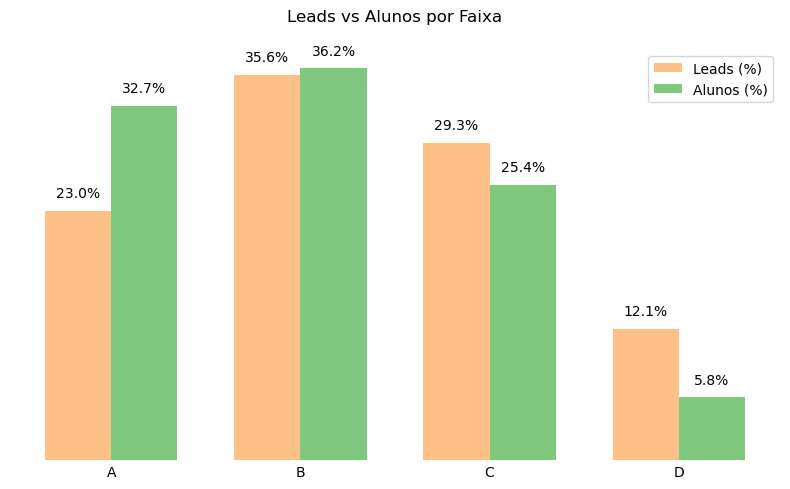

In [31]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [32]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
L28,84,30.5,108,39.3,67,24.4,16,5.8,673.21
L29,77,31.7,94,38.7,47,19.3,25,10.3,677.08
L30,98,27.8,146,41.5,78,22.2,30,8.5,669.94
L31,686,25.8,991,37.3,758,28.5,222,8.4,658.43
L32,1314,27.0,1866,38.3,1302,26.7,393,8.1,663.44
L33,646,26.2,892,36.2,715,29.1,208,8.5,658.01
L34,6047,21.6,9745,34.8,8441,30.1,3797,13.5,633.65


In [33]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
L28,10.0,55.6,4.0,22.2,4.0,22.2,0.0,0.0,673.21
L29,5.0,41.7,4.0,33.3,2.0,16.7,1.0,8.3,677.08
L30,9.0,37.5,10.0,41.7,3.0,12.5,2.0,8.3,669.94
L31,25.0,35.2,25.0,35.2,18.0,25.4,3.0,4.2,658.43
L32,23.0,26.1,36.0,40.9,21.0,23.9,8.0,9.1,663.44
L33,13.0,27.7,15.0,31.9,18.0,38.3,1.0,2.1,658.01
L34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,633.65


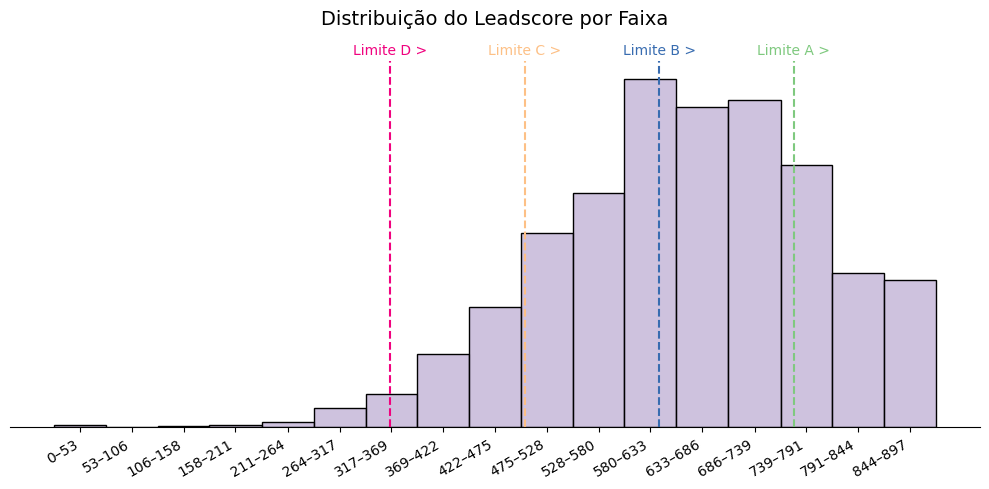

In [34]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [35]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 22794
Desses, já compraram: 186
Ainda não compraram: 22608


In [36]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38893 entries, 0 to 38892
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data                   38893 non-null  datetime64[ns]
 1   lancamentos            38893 non-null  object        
 2   email                  38893 non-null  object        
 3   whatsapp               38893 non-null  object        
 4   estado                 38893 non-null  object        
 5   idade                  38893 non-null  object        
 6   escolaridade           38893 non-null  object        
 7   renda                  38893 non-null  object        
 8   estado_civil           38893 non-null  object        
 9   filhos                 38893 non-null  object        
 10  escolheu_profissao     38893 non-null  object        
 11  dificuldade            38893 non-null  object        
 12  comprou                38893 non-null  int32         
 13  u

In [37]:
# Agrupa total de leads por criativo + faixa
distrib_faixa_por_criativo = (
    df_leads[
        (df_leads['lancamentos'] == 'L34') &
        (df_leads['utm_source'] == 'Facebook-Ads') &
        (df_leads['leadscore_faixa'].isin(['A', 'B', 'C', 'D']))
    ]
    .groupby(['utm_content', 'leadscore_faixa'])
    .size()
    .reset_index(name='qtd')
)

# Total de leads por criativo
totais_criativo = (
    distrib_faixa_por_criativo
    .groupby('utm_content')['qtd']
    .sum()
    .reset_index(name='total')
)

# Merge e cálculo da proporção
distrib_faixa_por_criativo = distrib_faixa_por_criativo.merge(totais_criativo, on='utm_content')
distrib_faixa_por_criativo['proporcao'] = (distrib_faixa_por_criativo['qtd'] / distrib_faixa_por_criativo['total']).round(3)

# Ordena por criativo e faixa
distrib_faixa_por_criativo = distrib_faixa_por_criativo.sort_values(['utm_content', 'leadscore_faixa'])

pd.set_option('display.max_rows', 100)
display(distrib_faixa_por_criativo)

,utm_content,leadscore_faixa,qtd,total,proporcao
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,A,951,4282,0.222
1,ads_001_captacao_video_stories_p1_imagem_sobral_1,B,1625,4282,0.379
2,ads_001_captacao_video_stories_p1_imagem_sobral_1,C,1244,4282,0.291
3,ads_001_captacao_video_stories_p1_imagem_sobral_1,D,462,4282,0.108
4,ads_002_captacao_video_stories_p1_imagem_raiz_1,A,54,253,0.213
5,ads_002_captacao_video_stories_p1_imagem_raiz_1,B,95,253,0.375
6,ads_002_captacao_video_stories_p1_imagem_raiz_1,C,71,253,0.281
7,ads_002_captacao_video_stories_p1_imagem_raiz_1,D,33,253,0.130
8,ads_003_captacao_video_stories_p1_video_mais_u...,A,121,462,0.262
9,ads_003_captacao_video_stories_p1_video_mais_u...,B,167,462,0.361


In [38]:
dominantes_a = distrib_faixa_por_criativo[
    (distrib_faixa_por_criativo['leadscore_faixa'].isin(['A'])) &
    (distrib_faixa_por_criativo['proporcao'] >= 0.20)
].copy()

# Ordena por criativo e faixa
dominantes_a = dominantes_a.sort_values(['utm_content', 'leadscore_faixa'])

display(dominantes_a)

,utm_content,leadscore_faixa,qtd,total,proporcao
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,A,951,4282,0.222
4,ads_002_captacao_video_stories_p1_imagem_raiz_1,A,54,253,0.213
8,ads_003_captacao_video_stories_p1_video_mais_u...,A,121,462,0.262
12,ads_004_captacao_video_stories_p1_video_4motiv...,A,135,557,0.242
16,ads_005_captacao_video_stories_p1_video_vemai_v1,A,920,3829,0.240
24,ads_007_captacao_video_stories_p2_ads02-cap-10...,A,35,133,0.263
28,ads_008_captacao_video_stories_p2_ads04-cap-10...,A,394,1681,0.234
32,ads_009-ads_008-ads_012,A,84,340,0.247
36,ads_009_captacao_video_stories_p2_ads05-cap-10...,A,1093,5205,0.210
40,ads_010_captacao_video_stories_p2_ads06-cap-10...,A,42,193,0.218


In [39]:
# 1. Padroniza colunas
df_invest_face['ad_name'] = df_invest_face['ad_name'].astype(str).str.strip().str.lower()
dominantes_a['utm_content'] = dominantes_a['utm_content'].astype(str).str.strip().str.lower()

# 2. Agrupa investimento por criativo
investimento_por_criativo = (
    df_invest_face
    .groupby('ad_name')['spend']
    .sum()
    .reset_index()
    .rename(columns={'ad_name': 'utm_content'})
)

# 3. Merge com dominantes A e B
dominantes_a_invest = dominantes_a.merge(investimento_por_criativo, on='utm_content', how='left')

# 4. Calcular CPL real por faixa dominante
dominantes_a_invest['proporcao_a'] = dominantes_a_invest['qtd'] / dominantes_a_invest['total']
dominantes_a_invest['invest_a'] = dominantes_a_invest['spend'] * dominantes_a_invest['proporcao_a']
dominantes_a_invest['cpl_faixa'] = dominantes_a_invest['invest_a'] / dominantes_a_invest['qtd']

# 🔢 Arredondar os valores
dominantes_a_invest['invest_a'] = dominantes_a_invest['invest_a'].round(2)
dominantes_a_invest['cpl_faixa'] = dominantes_a_invest['cpl_faixa'].round(2)

# 5. Exibir
dominantes_a_invest = dominantes_a_invest.sort_values(by='cpl_faixa')
display(dominantes_a_invest)

,utm_content,leadscore_faixa,qtd,total,proporcao,spend,proporcao_a,invest_a,cpl_faixa
6,ads_008_captacao_video_stories_p2_ads04-cap-10...,A,394,1681,0.234,2716.03,0.234384,636.59,1.62
8,ads_009_captacao_video_stories_p2_ads05-cap-10...,A,1093,5205,0.210,8819.54,0.209990,1852.02,1.69
11,ads_012_captacao_video_stories_p4_ads08-cap-10...,A,925,4143,0.223,7332.10,0.223268,1637.02,1.77
9,ads_010_captacao_video_stories_p2_ads06-cap-10...,A,42,193,0.218,417.87,0.217617,90.94,2.17
4,ads_005_captacao_video_stories_p1_video_vemai_v1,A,920,3829,0.240,8630.17,0.240272,2073.58,2.25
12,ads_013_captacao_video_stories_p5_ads 09 - req...,A,37,180,0.206,424.55,0.205556,87.27,2.36
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,A,951,4282,0.222,10169.67,0.222092,2258.61,2.37
10,ads_011_captacao_video_stories_p3_ads07-cap-10...,A,126,583,0.216,1480.44,0.216123,319.96,2.54
5,ads_007_captacao_video_stories_p2_ads02-cap-10...,A,35,133,0.263,340.47,0.263158,89.60,2.56
3,ads_004_captacao_video_stories_p1_video_4motiv...,A,135,557,0.242,1457.94,0.242370,353.36,2.62


In [40]:
# Agrupar por faixa e somar investimento e leads
cpl_por_faixa = (
    dominantes_a_invest
    .groupby('leadscore_faixa')
    .agg(
        total_leads=('qtd', 'sum'),
        total_investimento=('invest_a', 'sum')
    )
    .reset_index()
)

# Calcular CPL por faixa
cpl_por_faixa['cpl_real'] = cpl_por_faixa['total_investimento'] / cpl_por_faixa['total_leads']
cpl_por_faixa['cpl_real'] = cpl_por_faixa['cpl_real'].round(2)
cpl_por_faixa['total_investimento'] = cpl_por_faixa['total_investimento'].round(2)

display(cpl_por_faixa)

,leadscore_faixa,total_leads,total_investimento,cpl_real
0,A,4932,10333.84,2.1


In [41]:
dominantes_b = distrib_faixa_por_criativo[
    (distrib_faixa_por_criativo['leadscore_faixa'].isin(['B'])) &
    (distrib_faixa_por_criativo['proporcao'] >= 0.35)
].copy()

# Ordena por criativo e faixa
dominantes_b = dominantes_b.sort_values(['utm_content', 'leadscore_faixa'])

display(dominantes_b)

,utm_content,leadscore_faixa,qtd,total,proporcao
1,ads_001_captacao_video_stories_p1_imagem_sobral_1,B,1625,4282,0.379
5,ads_002_captacao_video_stories_p1_imagem_raiz_1,B,95,253,0.375
9,ads_003_captacao_video_stories_p1_video_mais_u...,B,167,462,0.361
13,ads_004_captacao_video_stories_p1_video_4motiv...,B,197,557,0.354
17,ads_005_captacao_video_stories_p1_video_vemai_v1,B,1366,3829,0.357
21,ads_006_captacao_video_stories_p2_ads 01 - fas...,B,18,51,0.353
33,ads_009-ads_008-ads_012,B,130,340,0.382
45,ads_011_captacao_video_stories_p3_ads07-cap-10...,B,209,583,0.358
49,ads_012_captacao_video_stories_p4_ads08-cap-10...,B,1452,4143,0.350
53,ads_013_captacao_video_stories_p5_ads 09 - req...,B,63,180,0.350


In [42]:
# 1. Padroniza colunas
df_invest_face['ad_name'] = df_invest_face['ad_name'].astype(str).str.strip().str.lower()
dominantes_b['utm_content'] = dominantes_b['utm_content'].astype(str).str.strip().str.lower()

# 2. Agrupa investimento por criativo
investimento_por_criativo = (
    df_invest_face
    .groupby('ad_name')['spend']
    .sum()
    .reset_index()
    .rename(columns={'ad_name': 'utm_content'})
)

# 3. Merge com dominantes A e B
dominantes_b_invest = dominantes_b.merge(investimento_por_criativo, on='utm_content', how='left')

# 4. Calcular CPL real por faixa dominante
dominantes_b_invest['proporcao_b'] = dominantes_b_invest['qtd'] / dominantes_b_invest['total']
dominantes_b_invest['invest_b'] = dominantes_b_invest['spend'] * dominantes_b_invest['proporcao_b']
dominantes_b_invest['cpl_faixa'] = dominantes_b_invest['invest_b'] / dominantes_b_invest['qtd']

# 🔢 Arredondar os valores
dominantes_b_invest['invest_b'] = dominantes_b_invest['invest_b'].round(2)
dominantes_b_invest['cpl_faixa'] = dominantes_b_invest['cpl_faixa'].round(2)

# 5. Exibir
dominantes_b_invest = dominantes_b_invest.sort_values(by='cpl_faixa')
display(dominantes_b_invest)

,utm_content,leadscore_faixa,qtd,total,proporcao,spend,proporcao_b,invest_b,cpl_faixa
8,ads_012_captacao_video_stories_p4_ads08-cap-10...,B,1452,4143,0.350,7332.10,0.350471,2569.69,1.77
4,ads_005_captacao_video_stories_p1_video_vemai_v1,B,1366,3829,0.357,8630.17,0.356751,3078.82,2.25
9,ads_013_captacao_video_stories_p5_ads 09 - req...,B,63,180,0.350,424.55,0.350000,148.59,2.36
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,B,1625,4282,0.379,10169.67,0.379496,3859.34,2.37
7,ads_011_captacao_video_stories_p3_ads07-cap-10...,B,209,583,0.358,1480.44,0.358491,530.72,2.54
3,ads_004_captacao_video_stories_p1_video_4motiv...,B,197,557,0.354,1457.94,0.353680,515.64,2.62
6,ads_009-ads_008-ads_012,B,130,340,0.382,911.13,0.382353,348.37,2.68
5,ads_006_captacao_video_stories_p2_ads 01 - fas...,B,18,51,0.353,151.83,0.352941,53.59,2.98
1,ads_002_captacao_video_stories_p1_imagem_raiz_1,B,95,253,0.375,865.04,0.375494,324.82,3.42
10,ads_015_captacao_estatico_stories_p2_l34-estát...,B,13,33,0.394,119.70,0.393939,47.15,3.63


In [43]:
# Agrupar por faixa e somar investimento e leads
cpl_por_faixa = (
    dominantes_b_invest
    .groupby('leadscore_faixa')
    .agg(
        total_leads=('qtd', 'sum'),
        total_investimento=('invest_b', 'sum')
    )
    .reset_index()
)

# Calcular CPL por faixa
cpl_por_faixa['cpl_real'] = cpl_por_faixa['total_investimento'] / cpl_por_faixa['total_leads']
cpl_por_faixa['cpl_real'] = cpl_por_faixa['cpl_real'].round(2)
cpl_por_faixa['total_investimento'] = cpl_por_faixa['total_investimento'].round(2)

display(cpl_por_faixa)

,leadscore_faixa,total_leads,total_investimento,cpl_real
0,B,5357,12203.37,2.28


In [44]:
dominantes_c = distrib_faixa_por_criativo[
    (distrib_faixa_por_criativo['leadscore_faixa'].isin(['C'])) &
    (distrib_faixa_por_criativo['proporcao'] >= 0.25)
].copy()

# Ordena por criativo e faixa
dominantes_c = dominantes_c.sort_values(['utm_content', 'leadscore_faixa'])

display(dominantes_c)

,utm_content,leadscore_faixa,qtd,total,proporcao
2,ads_001_captacao_video_stories_p1_imagem_sobral_1,C,1244,4282,0.291
6,ads_002_captacao_video_stories_p1_imagem_raiz_1,C,71,253,0.281
10,ads_003_captacao_video_stories_p1_video_mais_u...,C,122,462,0.264
14,ads_004_captacao_video_stories_p1_video_4motiv...,C,155,557,0.278
18,ads_005_captacao_video_stories_p1_video_vemai_v1,C,1088,3829,0.284
22,ads_006_captacao_video_stories_p2_ads 01 - fas...,C,17,51,0.333
26,ads_007_captacao_video_stories_p2_ads02-cap-10...,C,39,133,0.293
30,ads_008_captacao_video_stories_p2_ads04-cap-10...,C,536,1681,0.319
34,ads_009-ads_008-ads_012,C,87,340,0.256
38,ads_009_captacao_video_stories_p2_ads05-cap-10...,C,1571,5205,0.302


In [45]:
# 1. Padroniza colunas
df_invest_face['ad_name'] = df_invest_face['ad_name'].astype(str).str.strip().str.lower()
dominantes_c['utm_content'] = dominantes_c['utm_content'].astype(str).str.strip().str.lower()

# 2. Agrupa investimento por criativo
investimento_por_criativo = (
    df_invest_face
    .groupby('ad_name')['spend']
    .sum()
    .reset_index()
    .rename(columns={'ad_name': 'utm_content'})
)

# 3. Merge com dominantes A e B
dominantes_c_invest = dominantes_c.merge(investimento_por_criativo, on='utm_content', how='left')

# 4. Calcular CPL real por faixa dominante
dominantes_c_invest['proporcao_c'] = dominantes_c_invest['qtd'] / dominantes_c_invest['total']
dominantes_c_invest['invest_c'] = dominantes_c_invest['spend'] * dominantes_c_invest['proporcao_c']
dominantes_c_invest['cpl_faixa'] = dominantes_c_invest['invest_c'] / dominantes_c_invest['qtd']

# 🔢 Arredondar os valores
dominantes_c_invest['invest_c'] = dominantes_c_invest['invest_c'].round(2)
dominantes_c_invest['cpl_faixa'] = dominantes_c_invest['cpl_faixa'].round(2)

# 5. Exibir
dominantes_c_invest = dominantes_c_invest.sort_values(by='cpl_faixa')
display(dominantes_c_invest)

,utm_content,leadscore_faixa,qtd,total,proporcao,spend,proporcao_c,invest_c,cpl_faixa
7,ads_008_captacao_video_stories_p2_ads04-cap-10...,C,536,1681,0.319,2716.03,0.318858,866.03,1.62
9,ads_009_captacao_video_stories_p2_ads05-cap-10...,C,1571,5205,0.302,8819.54,0.301825,2661.96,1.69
12,ads_012_captacao_video_stories_p4_ads08-cap-10...,C,1229,4143,0.297,7332.10,0.296645,2175.03,1.77
10,ads_010_captacao_video_stories_p2_ads06-cap-10...,C,61,193,0.316,417.87,0.316062,132.07,2.17
4,ads_005_captacao_video_stories_p1_video_vemai_v1,C,1088,3829,0.284,8630.17,0.284147,2452.24,2.25
13,ads_013_captacao_video_stories_p5_ads 09 - req...,C,53,180,0.294,424.55,0.294444,125.01,2.36
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,C,1244,4282,0.291,10169.67,0.290518,2954.48,2.37
11,ads_011_captacao_video_stories_p3_ads07-cap-10...,C,169,583,0.290,1480.44,0.289880,429.15,2.54
6,ads_007_captacao_video_stories_p2_ads02-cap-10...,C,39,133,0.293,340.47,0.293233,99.84,2.56
3,ads_004_captacao_video_stories_p1_video_4motiv...,C,155,557,0.278,1457.94,0.278276,405.71,2.62


In [46]:
# Agrupar por faixa e somar investimento e leads
cpl_por_faixa = (
    dominantes_c_invest
    .groupby('leadscore_faixa')
    .agg(
        total_leads=('qtd', 'sum'),
        total_investimento=('invest_c', 'sum')
    )
    .reset_index()
)

# Calcular CPL por faixa
cpl_por_faixa['cpl_real'] = cpl_por_faixa['total_investimento'] / cpl_por_faixa['total_leads']
cpl_por_faixa['cpl_real'] = cpl_por_faixa['cpl_real'].round(2)
cpl_por_faixa['total_investimento'] = cpl_por_faixa['total_investimento'].round(2)

display(cpl_por_faixa)

,leadscore_faixa,total_leads,total_investimento,cpl_real
0,C,6512,13347.7,2.05


In [47]:
dominantes_d = distrib_faixa_por_criativo[
    (distrib_faixa_por_criativo['leadscore_faixa'].isin(['D'])) &
    (distrib_faixa_por_criativo['proporcao'] >= 0.05)
].copy()

# Ordena por criativo e faixa
dominantes_d = dominantes_d.sort_values(['utm_content', 'leadscore_faixa'])

display(dominantes_d)

,utm_content,leadscore_faixa,qtd,total,proporcao
3,ads_001_captacao_video_stories_p1_imagem_sobral_1,D,462,4282,0.108
7,ads_002_captacao_video_stories_p1_imagem_raiz_1,D,33,253,0.130
11,ads_003_captacao_video_stories_p1_video_mais_u...,D,52,462,0.113
15,ads_004_captacao_video_stories_p1_video_4motiv...,D,70,557,0.126
19,ads_005_captacao_video_stories_p1_video_vemai_v1,D,455,3829,0.119
23,ads_006_captacao_video_stories_p2_ads 01 - fas...,D,6,51,0.118
27,ads_007_captacao_video_stories_p2_ads02-cap-10...,D,14,133,0.105
31,ads_008_captacao_video_stories_p2_ads04-cap-10...,D,176,1681,0.105
35,ads_009-ads_008-ads_012,D,39,340,0.115
39,ads_009_captacao_video_stories_p2_ads05-cap-10...,D,735,5205,0.141


In [48]:
# 1. Padroniza colunas
df_invest_face['ad_name'] = df_invest_face['ad_name'].astype(str).str.strip().str.lower()
dominantes_d['utm_content'] = dominantes_d['utm_content'].astype(str).str.strip().str.lower()

# 2. Agrupa investimento por criativo
investimento_por_criativo = (
    df_invest_face
    .groupby('ad_name')['spend']
    .sum()
    .reset_index()
    .rename(columns={'ad_name': 'utm_content'})
)

# 3. Merge com dominantes A e B
dominantes_d_invest = dominantes_d.merge(investimento_por_criativo, on='utm_content', how='left')

# 4. Calcular CPL real por faixa dominante
dominantes_d_invest['proporcao_d'] = dominantes_d_invest['qtd'] / dominantes_d_invest['total']
dominantes_d_invest['invest_d'] = dominantes_d_invest['spend'] * dominantes_d_invest['proporcao_d']
dominantes_d_invest['cpl_faixa'] = dominantes_d_invest['invest_d'] / dominantes_d_invest['qtd']

# 🔢 Arredondar os valores
dominantes_d_invest['invest_d'] = dominantes_d_invest['invest_d'].round(2)
dominantes_d_invest['cpl_faixa'] = dominantes_d_invest['cpl_faixa'].round(2)

# 5. Exibir
dominantes_d_invest = dominantes_d_invest.sort_values(by='cpl_faixa')
display(dominantes_d_invest)

,utm_content,leadscore_faixa,qtd,total,proporcao,spend,proporcao_d,invest_d,cpl_faixa
7,ads_008_captacao_video_stories_p2_ads04-cap-10...,D,176,1681,0.105,2716.03,0.104700,284.37,1.62
9,ads_009_captacao_video_stories_p2_ads05-cap-10...,D,735,5205,0.141,8819.54,0.141210,1245.41,1.69
12,ads_012_captacao_video_stories_p4_ads08-cap-10...,D,537,4143,0.130,7332.10,0.129616,950.36,1.77
10,ads_010_captacao_video_stories_p2_ads06-cap-10...,D,23,193,0.119,417.87,0.119171,49.80,2.17
4,ads_005_captacao_video_stories_p1_video_vemai_v1,D,455,3829,0.119,8630.17,0.118830,1025.52,2.25
13,ads_013_captacao_video_stories_p5_ads 09 - req...,D,27,180,0.150,424.55,0.150000,63.68,2.36
0,ads_001_captacao_video_stories_p1_imagem_sobral_1,D,462,4282,0.108,10169.67,0.107894,1097.24,2.37
11,ads_011_captacao_video_stories_p3_ads07-cap-10...,D,79,583,0.136,1480.44,0.135506,200.61,2.54
6,ads_007_captacao_video_stories_p2_ads02-cap-10...,D,14,133,0.105,340.47,0.105263,35.84,2.56
3,ads_004_captacao_video_stories_p1_video_4motiv...,D,70,557,0.126,1457.94,0.125673,183.22,2.62


In [49]:
# Agrupar por faixa e somar investimento e leads
cpl_por_faixa = (
    dominantes_d_invest
    .groupby('leadscore_faixa')
    .agg(
        total_leads=('qtd', 'sum'),
        total_investimento=('invest_d', 'sum')
    )
    .reset_index()
)

# Calcular CPL por faixa
cpl_por_faixa['cpl_real'] = cpl_por_faixa['total_investimento'] / cpl_por_faixa['total_leads']
cpl_por_faixa['cpl_real'] = cpl_por_faixa['cpl_real'].round(2)
cpl_por_faixa['total_investimento'] = cpl_por_faixa['total_investimento'].round(2)

display(cpl_por_faixa)

,leadscore_faixa,total_leads,total_investimento,cpl_real
0,D,2752,5679.91,2.06


In [50]:
# ========================
# 1. Prepara os dados
# ========================
# Normaliza colunas
df_leads['utm_content'] = df_leads['utm_content'].astype(str).str.strip().str.lower()
df_invest_face['ad_name'] = df_invest_face['ad_name'].astype(str).str.strip().str.lower()

# ========================
# 2. Leads por criativo e faixa
# ========================
leads_faixa_criativo = (
    df_leads[
        (df_leads['lancamentos'] == 'L34') &
        (df_leads['utm_source'] == 'Facebook-Ads') &
        (df_leads['leadscore_faixa'].isin(['A', 'B', 'C', 'D']))
    ]
    .groupby(['utm_content', 'leadscore_faixa'])
    .size()
    .reset_index(name='qtd')
)

# Total por criativo
leads_total_criativo = (
    leads_faixa_criativo
    .groupby('utm_content')['qtd']
    .sum()
    .reset_index(name='total')
)

# Merge e proporção
leads_faixa_criativo = leads_faixa_criativo.merge(leads_total_criativo, on='utm_content')
leads_faixa_criativo['proporcao'] = leads_faixa_criativo['qtd'] / leads_faixa_criativo['total']

# ========================
# 3. Soma investimento por criativo
# ========================
investimento_por_criativo = (
    df_invest_face
    .groupby('ad_name')['spend']
    .sum()
    .reset_index()
    .rename(columns={'ad_name': 'utm_content'})
)

# ========================
# 4. Merge para atribuir investimento por faixa
# ========================
df_atribuido = leads_faixa_criativo.merge(investimento_por_criativo, on='utm_content', how='left')

# Remove criativos sem investimento
df_atribuido = df_atribuido[df_atribuido['spend'].notna()]

# Atribui investimento proporcional à faixa
df_atribuido['investimento_faixa'] = df_atribuido['spend'] * df_atribuido['proporcao']

# ========================
# 5. Resultado final por faixa
# ========================
resultado = (
    df_atribuido.groupby('leadscore_faixa')
    .agg({
        'qtd': 'sum',
        'investimento_faixa': 'sum'
    })
    .reset_index()
)

resultado['cpl_estimado'] = resultado['investimento_faixa'] / resultado['qtd']

# ========================
# 6. Exibir
# ========================
print("✅ CPL por faixa com 100% do investimento proporcionalmente distribuído:\n")
for _, row in resultado.iterrows():
    print(f"Faixa {row['leadscore_faixa']}:")
    print(f"  • Leads: {int(row['qtd'])}")
    print(f"  • Investimento estimado: R$ {row['investimento_faixa']:,.2f}")
    print(f"  • CPL estimado: R$ {row['cpl_estimado']:.2f}")
    print()


✅ CPL por faixa com 100% do investimento proporcionalmente distribuído:

Faixa A:
  • Leads: 4942
  • Investimento estimado: R$ 10,368.00
  • CPL estimado: R$ 2.10

Faixa B:
  • Leads: 7852
  • Investimento estimado: R$ 16,483.33
  • CPL estimado: R$ 2.10

Faixa C:
  • Leads: 6459
  • Investimento estimado: R$ 13,347.68
  • CPL estimado: R$ 2.07

Faixa D:
  • Leads: 2723
  • Investimento estimado: R$ 5,679.90
  • CPL estimado: R$ 2.09



# Modelo de Regressão

In [51]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "estado_civil",
    "filhos", 
    "escolheu_profissao",
    "dificuldade"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.757


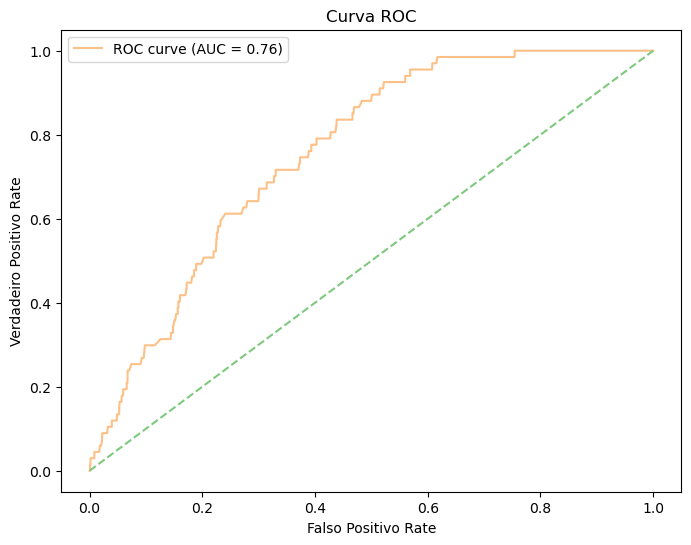

,Threshold,Precision,Recall,F1 Score
5,0.102041,0.100,0.030,0.046
4,0.081633,0.095,0.030,0.045
3,0.061224,0.053,0.030,0.038
1,0.020408,0.020,0.164,0.036
2,0.040816,0.025,0.045,0.032
7,0.142857,0.083,0.015,0.025
6,0.122449,0.062,0.015,0.024
0,0.000000,0.007,1.000,0.014
34,0.693878,0.000,0.000,0.000
37,0.755102,0.000,0.000,0.000


In [52]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [53]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.98
Erro médio absoluto (MAE): 11.83
MAE percentual: 1.73%


In [54]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.drop(columns=['email', 'whatsapp']).head(10)

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,...,utm_source,utm_medium,utm_campaign,utm_content,utm_term,escolaridade_original,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao
0,2025-01-27 17:31:57,L32,SP,26 - 35 anos,médio completo,de 3.000 a 5.000,união estável,sim,sonho de criança,falta de base escolar,...,whatsapp,grupos antigos,l32,none,None,None,659.27,B,0.027891,645.37
1,2024-11-20 10:56:47,L31,SP,46 - 55 anos,médio completo,até 1.000,divorciado(a) ou separado(a),sim,gosta da profissão,falta de oportunidade,...,instagram_feed,04_ll_1_envolvimento_30d,l31,video_vemai_v1,frio,None,525.46,C,0.002534,556.10
2,2025-01-28 01:45:29,L32,SP,26 - 35 anos,fundamental completo,desempregado,solteiro(a),não,sonho de criança,financeiro / dinheiro,...,tva,04_afinidade_luta,l32,video_5_motivos_yt,None,None,414.69,D,0.006182,442.40
3,2025-03-17 20:27:57,L33,SP,26 - 35 anos,médio completo,desempregado,solteiro(a),sim,sonho de criança,financeiro / dinheiro,...,instagram,bio,l33,none,None,None,674.73,B,0.006751,668.34
4,2025-03-23 22:39:51,L33,SP,26 - 35 anos,médio completo,de 1.000 a 3.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,...,instagram_stories,04_ll_10_lista_de_alunos,l33,video_vemai_v1_pag_f,frio,None,757.85,A,0.006732,739.15
5,2024-09-20 16:31:00,L30,RJ,acima de 56 anos,médio completo,até 1.000,solteiro(a),sim,gosta da profissão,idade,...,facebook_mobile_reels,01_listas_geral_pageview,l30,video_nao_tenho_dinheiro,quente,None,529.68,C,0.003028,572.06
6,2024-11-26 19:58:26,L31,RJ,46 - 55 anos,médio completo,até 1.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,...,vadeos,comentarios,youtube,none,None,None,583.81,C,0.003206,591.40
7,2025-01-29 11:27:55,L32,SP,26 - 35 anos,superior completo,até 1.000,solteiro(a),não,estabilidade de emprego,falta de tempo,...,tva,04_mercado_concurso,l32,video_entrevista_v2_yt,None,None,352.89,D,0.002557,394.36
8,2025-02-02 22:36:03,L32,Outro,26 - 35 anos,fundamental completo,de 3.000 a 5.000,solteiro(a),sim,sonho de criança,falta de base escolar,...,instagram_stories,04_concorrentes,l32,video_vemai_v1,frio,None,533.47,C,0.026588,536.98
9,2025-02-02 10:47:03,L32,RJ,26 - 35 anos,médio completo,de 3.000 a 5.000,solteiro(a),sim,estabilidade de emprego,falta de tempo,...,instagram_feed,00_envolvimento_60d_seguidores,l32,imagem_sobral_1,quente,None,615.32,C,0.003125,633.98


In [55]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,79,6,0,0
B,0,93,1,0
C,0,4,62,0
D,0,0,3,12


In [56]:
# 1. Preparar X com mesmo shape
X_novos_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_novos_leads = X_novos_leads.reindex(columns=X_reg.columns, fill_value=0)

# 2. Prever
df_leads["leadscore_regressao"] = modelo_reg.predict(X_novos_leads)

# 3. Classificar
df_leads["faixa_regressao"] = df_leads["leadscore_regressao"].apply(classificar_faixa)

comparativo = df_leads.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,7597,1355,0,0
B,213,13309,320,0
C,2,1757,9645,4
D,0,15,2245,2431


In [57]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

,% Respostas Diferentes
renda,6.6
escolaridade,3.9
escolheu_profissao,3.6
idade,2.3
estado_civil,1.0
filhos,0.0


In [58]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 20 de 305 respostas são diferentes em 'renda'


,email,renda_lead,renda_aluno
25,camilanobregamoraes@hotmail.com,de 1.000 a 3.000,desempregado
26,camilanobregamoraes@hotmail.com,desempregado,de 1.000 a 3.000
90,fatimasantossantos429@gmail.com,desempregado,de 1.000 a 3.000
91,fatimasantossantos429@gmail.com,de 1.000 a 3.000,desempregado
95,fdasilvadelnino@gmail.com,desempregado,até 1.000
96,fdasilvadelnino@gmail.com,até 1.000,desempregado
111,frangochickenman@gmail.com,até 1.000,de 3.000 a 5.000
112,frangochickenman@gmail.com,de 3.000 a 5.000,até 1.000
135,itallo.paim@gmail.com,de 1.000 a 3.000,de 3.000 a 5.000
136,itallo.paim@gmail.com,de 3.000 a 5.000,de 1.000 a 3.000



🔍 12 de 305 respostas são diferentes em 'escolaridade'


,email,escolaridade_lead,escolaridade_aluno
95,fdasilvadelnino@gmail.com,médio completo,fundamental completo
96,fdasilvadelnino@gmail.com,fundamental completo,médio completo
135,itallo.paim@gmail.com,médio completo,superior completo
136,itallo.paim@gmail.com,superior completo,médio completo
154,junior.rega12@gmail.com,fundamental completo,médio completo
155,junior.rega12@gmail.com,médio completo,fundamental completo
158,kelsonwilliams239@gmail.com,médio completo,fundamental completo
160,kelsonwilliams239@gmail.com,fundamental completo,médio completo
162,kelsonwilliams239@gmail.com,fundamental completo,médio completo
164,kelsonwilliams239@gmail.com,médio completo,fundamental completo



🔍 7 de 305 respostas são diferentes em 'idade'


,email,idade_lead,idade_aluno
158,kelsonwilliams239@gmail.com,até 25 anos,26 - 35 anos
159,kelsonwilliams239@gmail.com,até 25 anos,26 - 35 anos
160,kelsonwilliams239@gmail.com,26 - 35 anos,até 25 anos
163,kelsonwilliams239@gmail.com,26 - 35 anos,até 25 anos
296,kelsonwilliams239@gmail.com,26 - 35 anos,até 25 anos
300,vagna.2907@gmail.com,46 - 55 anos,36 - 45 anos
304,valdclebiof@gmail.com,46 - 55 anos,36 - 45 anos



🔍 0 de 305 respostas são diferentes em 'filhos'


,email,filhos_lead,filhos_aluno



🔍 3 de 305 respostas são diferentes em 'estado_civil'


,email,estado_civil_lead,estado_civil_aluno
90,fatimasantossantos429@gmail.com,união estável,casado(a)
91,fatimasantossantos429@gmail.com,casado(a),união estável
300,vagna.2907@gmail.com,none,casado(a)



🔍 11 de 305 respostas são diferentes em 'escolheu_profissao'


,email,escolheu_profissao_lead,escolheu_profissao_aluno
135,itallo.paim@gmail.com,gosta da profissão,sonho de criança
136,itallo.paim@gmail.com,sonho de criança,gosta da profissão
154,junior.rega12@gmail.com,sonho de criança,prestígio da carreira
155,junior.rega12@gmail.com,prestígio da carreira,sonho de criança
193,marinaldopedro39@gmail.com,sonho de criança,gosta da profissão
194,marinaldopedro39@gmail.com,gosta da profissão,sonho de criança
220,oficialviniciussiqueira@gmail.com,gosta da profissão,sonho de criança
221,oficialviniciussiqueira@gmail.com,sonho de criança,gosta da profissão
299,luiz.carlos.g@hotmail.com,sonho de criança,prestígio da carreira
302,fatimasantossantos429@gmail.comf,sonho de criança,gosta da profissão


In [59]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.7244794975108922
              precision    recall  f1-score   support

           0       1.00      0.72      0.83      9657
           1       0.01      0.57      0.03        67

    accuracy                           0.72      9724
   macro avg       0.50      0.64      0.43      9724
weighted avg       0.99      0.72      0.83      9724



In [60]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads = df_leads.sort_values("score_hibrido", ascending=False)

# Exibir os 10 primeiros leads rankeados
display(df_leads[["email", "leadscore_regressao", "leadscore_faixa", "probabilidade_conversao_modelo", "score_hibrido"]].drop(columns=['email']).head(10))

,leadscore_regressao,leadscore_faixa,probabilidade_conversao_modelo,score_hibrido
5881,895.456142,A,0.85124,0.9488
7662,895.456142,A,0.85124,0.9488
9474,895.456142,A,0.85124,0.9488
6539,895.456142,A,0.85124,0.9488
6237,895.456142,A,0.85124,0.9488
7183,895.456142,A,0.85124,0.9488
4044,895.456142,A,0.85124,0.9488
3281,895.456142,A,0.85124,0.9488
8934,895.456142,A,0.85124,0.9488
8736,895.456142,A,0.85124,0.9488


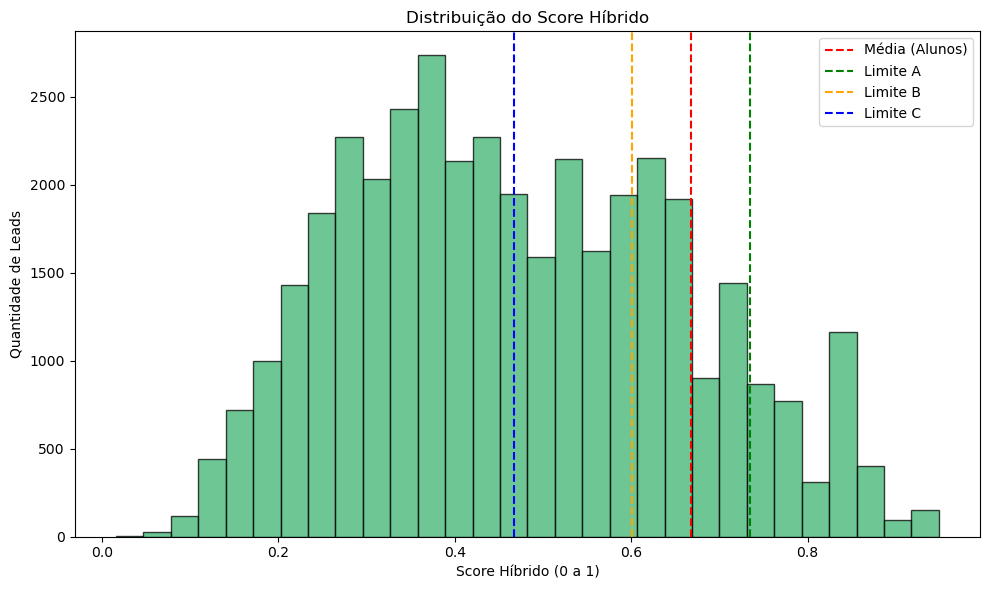

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,3541,88,2.5%
B,7172,98,1.4%
C,7920,54,0.7%
D,20260,27,0.1%


In [61]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [62]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,Probabilidade Relativa (0 - 1)
0,L28,0.60
1,L29,0.60
2,L30,0.59
3,L31,0.57
4,L32,0.59
5,L33,0.58
6,L34,0.43


In [63]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

,lancamentos,total_leads,compras_reais,taxa_real_conversao (%),probabilidade_media_modelo,score_hibrido_medio
0,L28,275,18,6.55,0.53,0.60
1,L29,243,12,4.94,0.52,0.60
2,L30,352,24,6.82,0.52,0.59
3,L31,2657,71,2.67,0.50,0.57
4,L32,4875,88,1.81,0.52,0.59
5,L33,2461,47,1.91,0.51,0.58
6,L34,28030,7,0.02,0.24,0.43


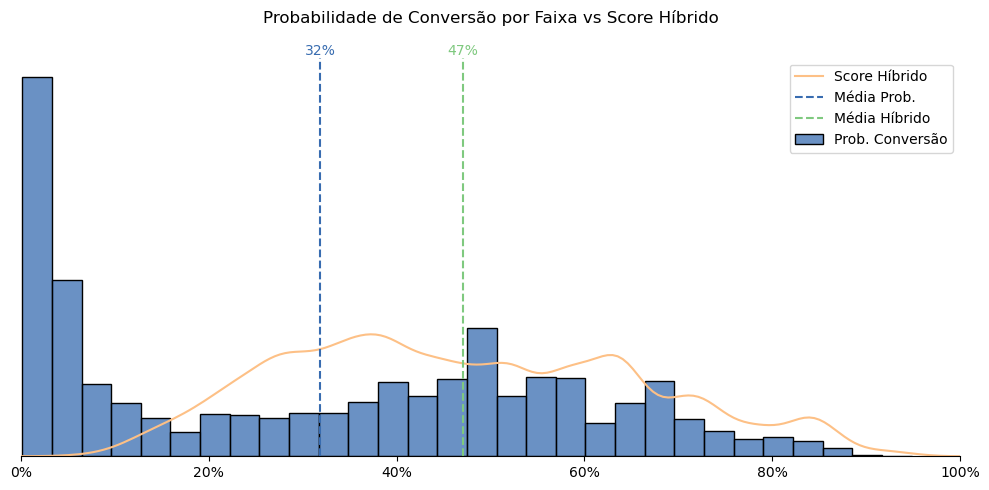

In [64]:
plot_probabilidade_conversao_vs_score(df_leads)

In [65]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.421 (0 = sem associação, 1 = associação perfeita)


In [66]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path("C:/Users/Camilo_Bica/data_science/consultoria/escola_policia/modelos")
path_modelos.mkdir(parents=True, exist_ok=True)

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, feature)
    tabelas_lift[feature] = tabela

joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\escola_policia\modelos


In [67]:
output_path = Path.cwd().parent / "dados"
df_leads.to_parquet(output_path / "leads_leadscore.parquet", index=False)
df_alunos.to_parquet(output_path / "alunos_leadscore.parquet", index=False)